In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
#from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import *
import cv2
import scipy as sp

In [2]:
bs = 16
SIZE = 128
tfms = get_transforms(do_flip=True,
                      #flip_vert=True, 
                      #max_rotate=360, 
                      #max_warp=0,
                      max_zoom=1.3, 
                      max_lighting=0.1,) 
                      #p_lighting=0.5,
                      #p_affine=1.0)

In [3]:
#making model
md_ef = EfficientNet.from_pretrained('efficientnet-b5', num_classes=1)

Loaded pretrained weights for efficientnet-b5


In [4]:
PATH = "../iris"

train_df=pd.read_csv(PATH+'/train.csv')
test_df=pd.read_csv(PATH+'/sample_submission.csv')

train = ImageList.from_df(train_df, 
                          path=PATH, 
                          cols='id_code', 
                          folder="train_images", 
                          suffix='.png')

test = ImageList.from_df(test_df,
                         path=PATH,
                         cols='id_code',
                         folder="test_images",
                         suffix='.png')

In [5]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def open_aptos2019_image(fn, convert_mode, after_open)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image,(0,0),10),-4,12,8)
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = open_aptos2019_image

In [6]:
data = (train.split_by_rand_pct(0.2) 
        .label_from_df(cols='diagnosis',label_cls=FloatList)
        .add_test(test)
        .transform(tfms,size=SIZE) #,resize_method=ResizeMethod.SQUISH,padding_mode='zeros'
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

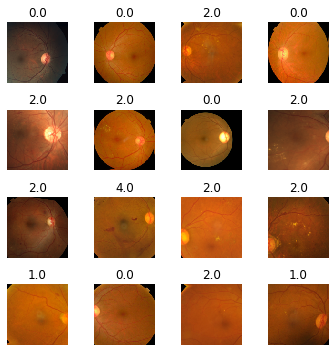

In [7]:
data.show_batch(rows=4,figsize=(5,5))

In [8]:
def quadratic_kappa(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

In [9]:
learn = Learner(data, 
                md_ef, 
                metrics = [quadratic_kappa], 
                model_dir="models").to_fp16() #mixup() 

#learn = cnn_learner(data,
#                      models.densenet169,
#                      metrics=[quadratic_kappa],
#                      pretrained=True).to_fp16()


epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.929204,1.131721,0.554631,02:58
1,0.711529,0.426311,0.829942,02:57
2,0.525321,0.481109,0.827347,02:58
3,0.503752,1.936001,0.687958,02:58
4,0.508812,0.828547,0.814470,02:57
5,0.419878,0.659248,0.851608,02:57
6,0.325494,0.309849,0.901527,02:57
7,0.273656,0.259909,0.903145,02:54
8,0.225758,0.224419,0.912123,02:54
9,0.233939,0.222231,0.912362,02:55


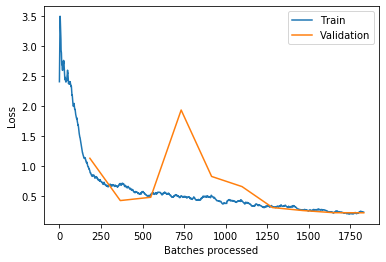

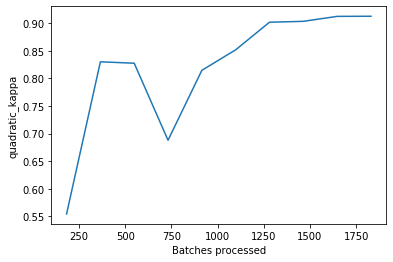

In [10]:
learn.fit_one_cycle(10,1e-3)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [26]:
learn.save("efficientnetphase1")

In [31]:
learn.export()

In [34]:
learn = learn.load('efficientnetphase1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


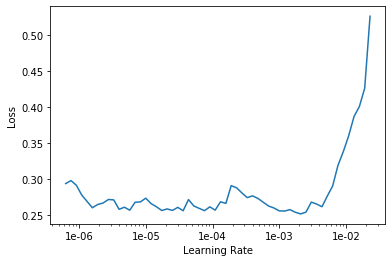

In [13]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5,1e-4)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.232231,0.236238,0.911621,02:58
1,0.229369,0.230118,0.910093,03:03


KeyboardInterrupt: 

In [ ]:
learn.save("efficientnetphase2")
learn.export()

In [35]:
valid_preds, valid_y = learn.get_preds(ds_type=DatasetType.Valid)

In [39]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [40]:
optR = OptimizedRounder()
optR.fit(valid_preds, valid_y)
coefficients = optR.coefficients()

valid_predictions = optR.predict(valid_preds, coefficients)[:,0].astype(int)
valid_score = cohen_kappa_score(valid_y.numpy().astype(int), valid_predictions, weights="quadratic")

In [41]:
print("coefficients:", coefficients)
print("validation score:", valid_score)

coefficients: [0.556938 1.356557 2.291956 3.303233]
validation score: 0.9193618471865388
